In [1]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torch.distributions.bernoulli import Bernoulli 
from torch.distributions.categorical import Categorical 
from torch.distributions.log_normal import LogNormal
from torch.distributions.normal import Normal

# Graphs
import matplotlib.pyplot as plt 
import seaborn as sns

# Internal packages
from data_loader import KidneyStoneDataset, ToTensor
from model import front_door_net, front_door_neg_loglik
from train import train

In [2]:
# Hyperparameters
BATCH_SIZE = 128
EPOCHS     = 150
LEARN_R    = 1e-3 #1e-3 #1e-2 # RMS
N_HU       = 16
#NLA = torch.tanh #torch.tanh #F.relu #torch.sigmoid 
NLA = nn.LeakyReLU(1) # For a linear neural network

sd_idx = [0, 1, 2, 3] # Standarize the two continuous variables

# Initialize the dataset
data = KidneyStoneDataset("./data/front_door_data.npy", transform=ToTensor(), idx_sd=sd_idx)
#data = KidneyStoneDataset("./data/ks_non_linear_data_lp.npy", transform=ToTensor(), idx_mean=mean_idx, idx_sd=sd_idx)
train_loader = DataLoader(data, batch_size=BATCH_SIZE)

# Initialize the model
model = front_door_net(N_HU, NLA)

# Optimizers
#optimizer = optim.SGD(model.parameters(), lr=LEARN_R)
optimizer = optim.RMSprop(model.parameters(), lr=LEARN_R)

In [3]:
cum_loss = train(model, optimizer, front_door_neg_loglik, train_loader, EPOCHS)

In [4]:
# First, we get the parameters of the size variable:
n_samples = 50
arbitrary_query = torch.tensor([1., 1., 1., 1.]) # It is only important that the first element is 1

mu_X, log_sigma_X, _, _, _, _, _, _ = model(arbitrary_query.unsqueeze(0))
sigma_X = torch.exp(log_sigma_X)

X_dist = Normal(mu_X, sigma_X)
X_samples = X_dist.sample((n_samples,)).view(n_samples,1)

In [5]:
_, _, mu_Z, log_sigma_Z, _, _, _, _ = model(torch.tensor(data.ks_dataset).float())

# Samples from Z given X
sigma_Z = torch.exp(log_sigma_Z)
dist_Z  = Normal(mu_Z, sigma_Z)
samples_Z = dist_Z.sample()

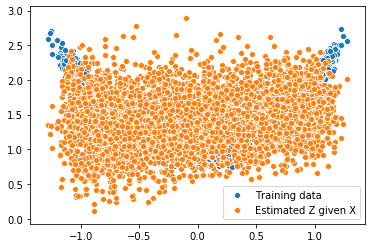

In [6]:
ax = sns.scatterplot(x=data.ks_dataset[:,0], y=data.ks_dataset[:,1], label="Training data") # Real data
ax = sns.scatterplot(x=data.ks_dataset[:,0], y=(samples_Z*data.sd[1]).detach().numpy()[:,0], label="Estimated Z given X")

# do(X=0)

In [7]:
# Front door
# sum(z) P(Z=z | X=int_x) sum(x') P(Y|X=x', Z=z)P(X=x')
n_samples = 5000

intervention_query = torch.tensor([0., 1., 1., 1.])/data.sd[0] # x == 0

# P(Z=z | X=int_x)
mu_X, log_sigma_X, mu_Z, log_sigma_Z, _, _, _, _ = model(intervention_query.unsqueeze(0))

sigma_X = torch.exp(log_sigma_X)
sigma_Z = torch.exp(log_sigma_Z)

Z_dist = Normal(mu_Z, sigma_Z)
Z_samples = Z_dist.sample((n_samples,)).view(n_samples,1)

# P(X=x')
X_dist = Normal(mu_X, sigma_X)
X_samples = X_dist.sample((n_samples,)).view(n_samples,1)

# P(Y|X=x', Z=z)
# Pack the samples from the distributions:
ZX_samples = torch.cat([X_samples, Z_samples, torch.ones([n_samples, 2])], dim=1)
_, _, _, _, _, _, mu_ZX_Y_0, _ = model(ZX_samples)

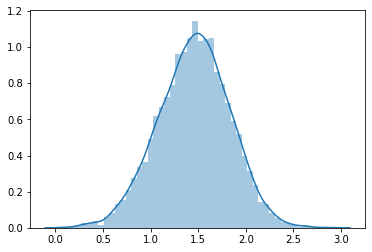

In [8]:
ax = sns.distplot((samples_Z*data.sd[1]).detach().numpy()[:,0])

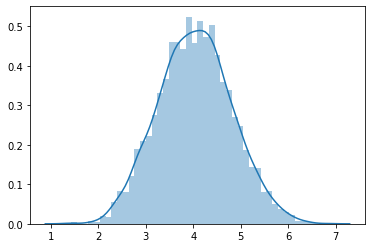

In [9]:
ax = sns.distplot((mu_ZX_Y_0*data.sd[2]).detach().numpy())

# do(X=1)

In [10]:
# Front door
# sum(z) P(Z=z | X=int_x) sum(x') P(Y|X=x', Z=z)P(X=x')
n_samples = 5000

intervention_query = torch.tensor([0.5, 0., 1., 1.])/data.sd[0] # x == 0.5

# P(Z=z | X=int_x)
mu_X, log_sigma_X, mu_Z, log_sigma_Z, _, _, _, _ = model(intervention_query.unsqueeze(0))
sigma_X = torch.exp(log_sigma_X)
sigma_Z = torch.exp(log_sigma_Z)

Z_dist = Normal(mu_Z, sigma_Z)
Z_samples = Z_dist.sample((n_samples,)).view(n_samples,1)

# P(X=x')
X_dist = Normal(mu_X, sigma_X)
X_samples = X_dist.sample((n_samples,)).view(n_samples,1)

# P(Y|X=x', Z=z)
# Pack the samples from the distributions:
ZX_samples = torch.cat([X_samples, Z_samples, torch.ones([n_samples, 2])], dim=1)
_, _, _, _, _, _, mu_ZX_Y_05, _ = model(ZX_samples)

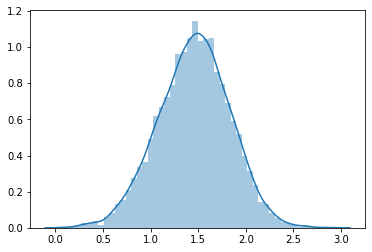

In [11]:
ax = sns.distplot((samples_Z*data.sd[1]).detach().numpy()[:,0])

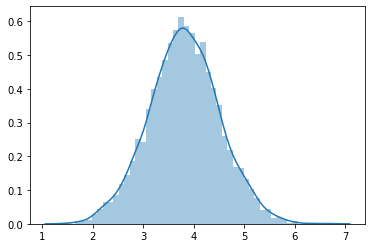

In [12]:
ax = sns.distplot((mu_ZX_Y_05*data.sd[2]).detach().numpy())

# Both at the same time 

In [13]:
# you can get these from NB 6
%store -r test_1_0
%store -r test_1_05

In [14]:
# The effect
print(torch.mean(mu_ZX_Y_05*data.sd[2])-torch.mean(mu_ZX_Y_0*data.sd[2]))
print(np.mean(test_1_05)-np.mean(test_1_0))

tensor(-0.2229, grad_fn=<SubBackward0>)
-1.0134417660986692


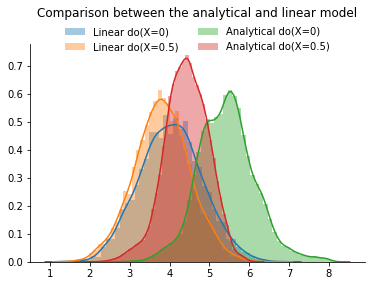

In [15]:
ax = sns.distplot((mu_ZX_Y_0*data.sd[2]).detach().numpy(), label="Linear do(X=0)")
ax = sns.distplot((mu_ZX_Y_05*data.sd[2]).detach().numpy(), label="Linear do(X=0.5)")
ax = sns.distplot(test_1_0, label="Analytical do(X=0)")
ax = sns.distplot(test_1_05, label="Analytical do(X=0.5)")
plt.title("Comparison between the analytical and linear model", y=1.10)
ax.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.10), borderaxespad=0, frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("./results/linear.pdf", ppi=300, bbox_inches='tight');

# Debugging the model

## Using the original distribution of x, what do we get in subsequent steps?

In [16]:
U_dist_a    = Normal(loc=0, scale=1.)
U_samples_a = U_dist_a.sample((1,n_samples))

X_dist_a    = Normal(torch.sin(U_samples_a), 0.1)
X_samples_a = X_dist_a.sample().view(n_samples,1)/data.sd[0]

Z_dist_a_0    = Normal(1+((-torch.zeros_like(X_samples_a))**2), 0.1)
Z_samples_a_0 = Z_dist_a_0.sample()/data.sd[1]

Z_dist_a_05    = Normal(1+(-torch.ones_like(X_samples_a)*0.5)**2, 0.1)
Z_samples_a_05 = Z_dist_a_05.sample()/data.sd[1]

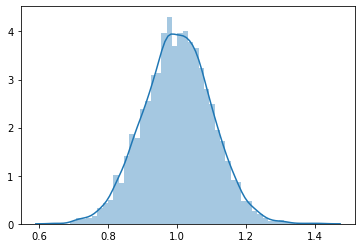

In [17]:
ax= sns.distplot((Z_samples_a_0*data.sd[1]).detach().numpy())

In [18]:
# P(Y|X=x', Z=z)
# Do(X=0)
ZX_samples = torch.cat([X_samples_a, Z_samples_a_0, torch.ones([n_samples, 2])], dim=1)
_, _, _, _, _, _, mu_ZX_Y_0, _ = model(ZX_samples)

# Do(X=0.5)
ZX_samples = torch.cat([X_samples_a, Z_samples_a_05, torch.ones([n_samples, 2])], dim=1)
_, _, _, _, _, _, mu_ZX_Y_05, _ = model(ZX_samples)

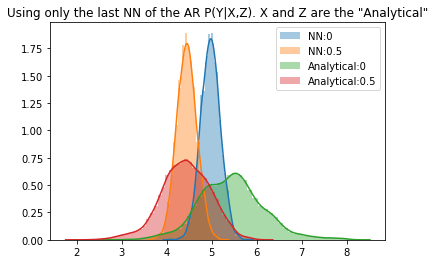

In [19]:
ax = sns.distplot((mu_ZX_Y_0*data.sd[2]).detach().numpy(), label="NN:0")
ax = sns.distplot((mu_ZX_Y_05*data.sd[2]).detach().numpy(), label="NN:0.5")
ax = sns.distplot(test_1_0, label="Analytical:0")
ax = sns.distplot(test_1_05, label="Analytical:0.5")
plt.legend();
plt.title("Using only the last NN of the AR P(Y|X,Z). X and Z are the \"Analytical\"");

## Now let' try to do the same using samples from the NN P(Z|X=x)

In [20]:
X_dist_a    = Normal(torch.sin(U_samples_a), 0.1)
X_samples_a = X_dist_a.sample().view(n_samples,1)/data.sd[0]

Z_dist_a_0    = Normal(1+((-torch.zeros_like(X_samples_a))**2), 0.1)
Z_samples_a_0 = Z_dist_a_0.sample()/data.sd[1]

Z_dist_a_05    = Normal(1+(-torch.ones_like(X_samples_a)*0.5)**2, 0.1)
Z_samples_a_05 = Z_dist_a_05.sample()/data.sd[1]

In [21]:
# X=0
arbitrary_query = torch.tensor([0., 1., 1., 1.])/data.sd[0]

_, _, mu_Z, log_sigma_Z, _, _, _, _ = model(arbitrary_query.view(-1, 4))
sigma_Z = torch.exp(log_sigma_Z)

Z_dist = Normal(mu_Z, sigma_Z)
Z_samples_0 = Z_dist.sample((n_samples,)).view(n_samples,1)

# X=0.5
arbitrary_query = torch.tensor([0.5, 1., 1., 1.])/data.sd[0]

_, _, mu_Z, log_sigma_Z, _, _, _, _ = model(arbitrary_query.view(-1, 4))
sigma_Z = torch.exp(log_sigma_Z)

Z_dist = Normal(mu_Z, sigma_Z)
Z_samples_05 = Z_dist.sample((n_samples,)).view(n_samples,1)

# P(Y|X=x', Z=z)
# Do(X=0)
ZX_samples = torch.cat([X_samples_a, Z_samples_0, torch.ones([n_samples, 2])], dim=1)
_, _, _, _, _, _, mu_ZX_Y_0, _ = model(ZX_samples)

# Do(X=0.5)
ZX_samples = torch.cat([X_samples_a, Z_samples_05, torch.ones([n_samples, 2])], dim=1)
_, _, _, _, _, _, mu_ZX_Y_05, _ = model(ZX_samples)

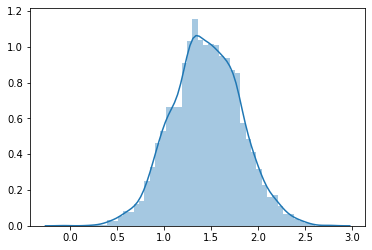

In [22]:
ax = sns.distplot((Z_samples_0*data.sd[1]).detach().numpy())

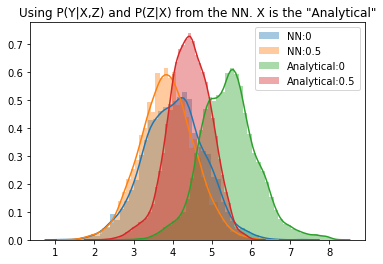

In [23]:
ax = sns.distplot((mu_ZX_Y_0*data.sd[2]).detach().numpy(), label="NN:0")
ax = sns.distplot((mu_ZX_Y_05*data.sd[2]).detach().numpy(), label="NN:0.5")
ax = sns.distplot(test_1_0, label="Analytical:0")
ax = sns.distplot(test_1_05, label="Analytical:0.5")
plt.legend();
plt.title("Using P(Y|X,Z) and P(Z|X) from the NN. X is the \"Analytical\"");